**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

from keras.optimizers import Adam
from keras.layers.core import Flatten

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

Using TensorFlow backend.


# MiniProject #3: Deep Reinforcement Learning

### Student : Yonatan DELORO 
### Contact : yonatan.deloro@eleves.enpc.fr

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

$$R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})]$$

where: 
$$p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) $$

[Note : I assumed there was a small typo in the indices here, and rewrote : 

$$p^{\pi}(a_{0},s_{1},a_{1},s_{2},...,s_{T-1},a_{T-1},s_{T})= \prod_{t=0}^{T-1}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t})
$$

where $s_0$ denotes the initial state.]

We note the $Q$-function:

$$ Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] $$

Thus, the optimal Q function is:
$$Q^*(s,a)=\max_{\pi}Q^\pi(s,a) $$

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else:
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

> - At train time ("train" = True) : With a probability $\epsilon$, the agent chooses an action uniformly at random (exploration of the environment). Otherwise (with a probability $1-\epsilon$) it will choose the action maximizing the expected cumulative reward from his current state $s$, or in other words the action $a$ such that the Q-value of the pair $(s,a)$ is maximal (exploitation of the currently learnt policy). 

> - At test time  ("train" = False) : The agent follows the learnt policy, ie. chooses the action maximizing the expected cumulative reward from his current state $s$, ie. the action $a$ such that the Q-value of the pair $(s,a)$ is maximal (only exploitation).

> - $\epsilon$ is essential as it **tradeoffs between exploration of the environment and exploitation of the currently learnt policy**. Indeed, if the agent only exploited ($\epsilon=0$), it would obviously never access to some potentially more interesting states than the currently exploited ones, as it would never update the Q-values of some pairs (state, action). At the opposite, if the agent only explored ($\epsilon=1$), the agent would certainly need an enormous amount of time to assess any pair (state,action) especially if positive rewards are delayed (ie. if several moves are needed to reach a positive reward) : thus the agent would learn very slowly, and even worse if the game is over at the end of a short horizon. 

> - We will set $\epsilon$ to 0.1 until Q10. From Q10, we will begin with a high $\epsilon$ and decrease it throughout the training (since, the more the agent will have already spent time in the environment, the more we may want to favor exploitation over exploration).

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        # board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0 #fixed typo
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1  #fixed typo

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x -1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x +1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]
        
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        
        self.board[self.x,self.y] = 0
        self.board[self.position < 0] = 0 #I added this line  (cf. justification below)
        
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature= 0.3 
epochs_train=150 # set small when debugging
epochs_test=30  # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

> - The array "position" gives to the rat the information of where it can go among the cells it sees (0 if the cell is accessible, -1 if not (board boundary), and 1 if the rat is already in the cell).

> - The array "board" gives to the rat the rewards present in each cell he sees (value of 0.5 if there is a cheese in the cell, of -1 if there is a poison, 0 if there is nothing). 

> Note : I modified two things in the code : first, i added the border at the right of the board (missing) ; secondly, i removed any cheese/poison in the boundary areas.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent,env,epochs,prefix='',return_trajectories=False):
    
    #if return trajectories is True, returns the visited pairs (state, action) in a list
    #(useful for the bonus question, ie. for the training of the Mimicker agent)
    
    if return_trajectories:
        trajectories = []
        
    score = 0
        
    for e in range(epochs):
                
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
                        
            # The agent performs an action
            action = agent.act(state, train=False)
            
            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action)
            
            if return_trajectories:
                trajectories.append((prev_state,action))

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward
        
        # Save as a mp4 
        if e<3:  #we will save only a few test trajectories
            env.draw(prefix+str(e+1))

        # Update stats
        score_episode = win-lose 
        score += score_episode

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    
    if return_trajectories:
        return trajectories

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random1.mp4'))

Win/lose count 10.0/13.0. Average score (-3.0)
Win/lose count 10.0/12.0. Average score (-2.5)
Win/lose count 10.5/11.0. Average score (-1.8333333333333333)
Win/lose count 15.0/15.0. Average score (-1.375)
Win/lose count 5.5/18.0. Average score (-3.6)
Win/lose count 6.5/15.0. Average score (-4.416666666666667)
Win/lose count 16.5/15.0. Average score (-3.5714285714285716)
Win/lose count 9.5/12.0. Average score (-3.4375)
Win/lose count 6.0/10.0. Average score (-3.5)
Win/lose count 8.5/22.0. Average score (-4.5)
Win/lose count 8.0/13.0. Average score (-4.545454545454546)
Win/lose count 12.0/27.0. Average score (-5.416666666666667)
Win/lose count 6.5/22.0. Average score (-6.1923076923076925)
Win/lose count 17.5/12.0. Average score (-5.357142857142857)
Win/lose count 7.5/16.0. Average score (-5.566666666666666)
Win/lose count 9.5/18.0. Average score (-5.75)
Win/lose count 4.0/12.0. Average score (-5.882352941176471)
Win/lose count 5.5/16.0. Average score (-6.138888888888889)
Win/lose count 1

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}

> **My answer** :

> I assumed there were small typos in the assertions to prove. Let us rewrite the question first : 

> 1. Let $\pi$ be a policy, show that: $$Q^{\pi}(s,a)=E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{\pi}(s',a')]$$

> 2. Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds:  $$Q^{*}(s,a)=E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')]$$

> 3. Finally, deduce that a plausible objective is:
$$\mathcal{L}(\theta)=E_{s' \sim p(.|s,a)}\Vert r(s,a) +\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}$$


***

> **Question 1**

> $Q^{\pi}(s,a)$ is defined as the expected cumulative reward over trajectories beginning in state $s$ with action $a$ and following policy $\pi$. We can rewrite it as :


> $$\begin{align*} 
Q^\pi(s,a) &=E_{p^{\pi}}[\sum_{0 \leq t}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \\ 
&= r(s, a) + \gamma E_{p^{\pi}}[\sum_{1 \leq t} \gamma^{t - 1} r(s_t,a_t)|s_0=s,a_0=a] \\ &= r(s, a) + \gamma \sum_{s'} \mathbb{P}(s_1 = s' | s_0 = s,a_0=a) \sum_{a'} \pi(a'|s') E_{p^{\pi}}[\sum_{1 \leq t} \gamma^{t - 1} r(s_t,a_t)|s_1=s',a_1=a'] \\ 
&= r(s, a) + \gamma \sum_{s'}  p(s'|s,a)  \sum_{a'} \pi(a'|s') E_{p^{\pi}}[\sum_{0 \leq t} \gamma^{t} r(s_t,a_t)|s_0=s',a_0=a'] \\
& = r(s,a) + \gamma \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a')
\end{align*}$$


> This is the so-called Bellman equation (which tells that the expected discounted cumulative reward in state $s$ taking action $a$ is the sum of the immediate reward $r(s,a)$ and of the expectation of the discounted cumulative reward over all new reachable state $s' \sim p(.|s,a)$ and taking action from state $s'$ following the policy $\pi$ (ie. choosing $a' \sim \pi(.|s')$)).

> Then, $$\begin{align*}
Q^{\pi}(s,a)& = r(s,a) + \gamma \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a') \\
&= \sum_{s'} p(s'|s,a) \left( r(s,a) + \gamma \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a')\right) \\
&= \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  \left( r(s,a) + \gamma Q^{\pi}(s',a') \right) \\
&=E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{align*}$$ 


***

> **Question 2**


> Denoting $Q^{*} = Q^{\pi^*}$ the state-action value function associated to the optimal policy, 

$$\begin{align*}
Q^{*}(s,a) &= E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{*}(s',a')] \\
&=E_{s'\sim p(.|s,a)}   \left[ r(s,a) + \gamma  \sum_{a'} \pi(a'|s') Q^{*}(s',a') \right]
\end{align*}$$ 


> But the optimal policy $\pi^*$ satisfies for any action $a$ : $$\pi^*(a|s) = 1_{a = a_0} $$ where we set : $$a_0 = \arg \max_{a} Q^{*}(s,a)$$

> Hence : $$\begin{align*} 
Q^{*}(s,a) &= E_{s'\sim p(.|s,a)} \left[ r(s,a)+\gamma Q^{*} \left( s',\arg \max_{a'} Q^{*}(s',a') \right) \right] \\
&=E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')] 
\end{align*}$$ 

*** 

> **Question 3**

> Hence :  $$ E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')- Q^{*}(s,a) ] = 0 $$

> Therefore, such matrix $Q^{*}$ will minimize the following loss : $$
\mathcal{L}(\theta)=E_{s' \sim p(.|s,a)}\Vert r(s,a) +\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
$$


***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

[Note : I assumed that at state $s_t$, we select the action $a_t$ following an $\epsilon$-greedy policy (ie. the one with highest $Q_t$ value with probability 1-$\epsilon$, and uniformly at random otherwise]

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory)>self.max_memory:
            self.memory = self.memory[-self.max_memory:]

    def random_access(self):
        idx = np.random.randint(len(self.memory))
        return self.memory[idx]

***
The pipeline we will use for training is given below:

In [10]:
def train(agent,env,epoch,prefix=''):
    
    history_losses = []
    history_scores = []    
    
    score = 0
    
    for e in range(epoch):
            
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        loss = 0

        win = 0
        lose = 0
        
        t = 0

        while not game_over:
            
            # The agent performs an action
            action = agent.act(state, train=True)

            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)
            
            t+=1
            
        loss /= t
            
        history_losses.append(loss)

        # Save as a mp4
        if (e+1) % 50 == 0:
            env.draw(prefix+str(e+1))

        # Update stats
        score_episode = win-lose
        score += score_episode
        history_scores.append(score_episode)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, score_episode))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
    return history_losses, history_scores

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [11]:
class DQN(Agent):
    def __init__(self, grid_size = 10.,  epsilon = 0.1, memory_size=100, batch_size = 16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        state_action_values = self.model.predict(s[None,:,:,:]).flatten()
        return np.argmax(state_action_values)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        
        steps = [self.memory.random_access() for i in range(self.batch_size)]
        
        #storing init states
        input_states = np.array([s[0] for s in steps])
        
        #storing next_states, played actions, rewards, and booleans game_over 
        next_state = np.array([s[1] for s in steps])
        tmp = np.array([s[2:] for s in steps])
        played_action = tmp[:,0].astype(int)
        reward = tmp[:,1]
        game_over = tmp[:,2]
        
        #computing current assessments of q(init state,action) for any possible action from init state
        target_q = self.model.predict(input_states)
        
        #reassessing q(init state,action) for the specific action played from init state
        q_next_state = self.model.predict(next_state) #q-values in the next state for all possible actions
        target_q_played_action = reward  + (1-game_over) * self.discount * np.max(q_next_state,axis=1) 
        for i in range(self.batch_size):
            target_q[i, played_action[i]] = target_q_played_action[i]
        
        #clipping the target to avoid exploiding gradients.
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        
        model.compile("sgd", "mse")
        
        self.model = model


class DQN_FC(DQN):
    def __init__(self, lr=0.1, *args, **kwargs):
        super(DQN_FC, self).__init__(*args,**kwargs)
        
        # NN Model
        
        model = Sequential()
        model.add(Flatten(input_shape = (5,5,self.n_state,)))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16))
        model.add(Activation('relu'))
        model.add(Dense(self.n_action))
        
        model.summary()
        
        opt = sgd(lr=lr, decay=1e-4, momentum=0.0)
        model.compile(loss="mse", optimizer = opt)
        
        self.model = model

In [12]:
env = Environment(grid_size=size, max_time=T, temperature=temperature)
agent_dqn_fc = DQN_FC(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
history_losses_dqn_fc, history_scores_dqn_fc = train(agent_dqn_fc, env, epochs_train, prefix='fc_train')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1632      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 2,228
Trainable params: 2,228
Non-trainable params: 0
_________________________________________________________________
Epoch 00

Epoch 120/150 | Loss 0.0100 | Win/lose count 10.0/6.0 (4.0)
Epoch 121/150 | Loss 0.0099 | Win/lose count 8.5/0 (8.5)
Epoch 122/150 | Loss 0.0112 | Win/lose count 8.0/0 (8.0)
Epoch 123/150 | Loss 0.0102 | Win/lose count 7.0/2.0 (5.0)
Epoch 124/150 | Loss 0.0107 | Win/lose count 21.5/1.0 (20.5)
Epoch 125/150 | Loss 0.0098 | Win/lose count 19.0/1.0 (18.0)
Epoch 126/150 | Loss 0.0123 | Win/lose count 1.0/2.0 (-1.0)
Epoch 127/150 | Loss 0.0118 | Win/lose count 10.0/1.0 (9.0)
Epoch 128/150 | Loss 0.0118 | Win/lose count 5.0/1.0 (4.0)
Epoch 129/150 | Loss 0.0115 | Win/lose count 18.0/6.0 (12.0)
Epoch 130/150 | Loss 0.0117 | Win/lose count 8.5/4.0 (4.5)
Epoch 131/150 | Loss 0.0115 | Win/lose count 19.5/1.0 (18.5)
Epoch 132/150 | Loss 0.0147 | Win/lose count 16.0/5.0 (11.0)
Epoch 133/150 | Loss 0.0104 | Win/lose count 14.0/1.0 (13.0)
Epoch 134/150 | Loss 0.0114 | Win/lose count 11.5/0 (11.5)
Epoch 135/150 | Loss 0.0138 | Win/lose count 8.5/1.0 (7.5)
Epoch 136/150 | Loss 0.0119 | Win/lose count 

In [13]:
HTML(display_videos('fc_train150.mp4'))

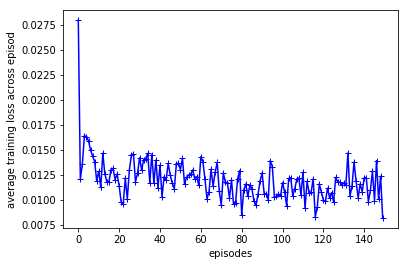

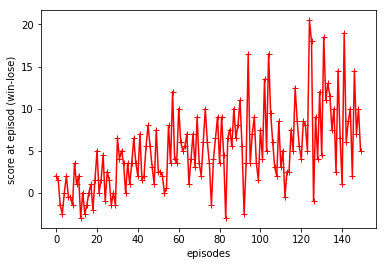

In [14]:
plt.plot(history_losses_dqn_fc,marker="+",color="b")
plt.xlabel("episodes") ; plt.ylabel("average training loss across episod") 
plt.show()

plt.plot(history_scores_dqn_fc,marker="+",color="r")
plt.xlabel("episodes") ; plt.ylabel("score at episod (win-lose)") 
plt.show()

> The fully connected network which led to the best outcomes is composed of two hidden layers with 32 and 16 neurons respectively, followed each by relu activations. A higher number of hidden layers seemed to lead to overfitting, which the dropout strategy did not really manage to face.  I used a learning rate of 0.1, a memory of size 2000, and a batch size of 32.

> As mentionned in the question, we observe that the average loss per episode oscillates throughout the training whenever the rat starts to eat more cheese than poison, but the score per episode keeps increasing despite these oscillations. This is not completely unexpected : indeed, as the rat plays better, it gets positive rewards and it may also encounter more difficult situations (with less cheese directly around him) and thus face harder estimations of Q-values (because of delayed rewards). In addition, we are using the same network to estimate Q-targets ($r(s,a)+\gamma \max_{a'} Q(s',a')$) and Q-values ($Q(s,a)$), thus, at each iteration, we get closer to a target which is itself moving, which contributes to the loss oscillations too. 

> Given that the loss oscillations do not translate into a plateau/decrease of performances, I did not choose a training stopping criteria based on the loss evolution, but chose to fix instead a large number of epochs (chosen empirically, equal to 150, looking at the score evolution throughout training). I prefered this simple strategy to a criterium based upon the score evolution, as the score often oscillated too in practice from one episode to the other.

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [15]:
class DQN_CNN(DQN):
    def __init__(self, lr=0.1, *args, **kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
                
        model = Sequential() 
    
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(5,5,self.n_state,)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.n_action))

        model.summary()
        
        opt = sgd(lr=lr, decay=1e-4, momentum=0.0)
        model.compile(loss="mse", optimizer = opt)
        
        self.model = model

In [16]:
env = Environment(grid_size=size, max_time=T, temperature=temperature)
agent_dqn_cnn = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
history_losses_dqn_cnn, history_scores_dqn_cnn = train(agent_dqn_cnn,env,epochs_train,prefix='cnn_train')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 16)          304       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 16)          2320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 2,692
Trainable params: 2,692
Non-trainable params: 0
_________________________________________________________________
Epoch 000/150 | Loss 0.0087 | Win/lose count 1.0/2.0 (-1.0)
Epoch 001/150 | Loss 0.0040 | Win/lose count 0.5/2.0 (-1.5)
Epoch 002/150 | Loss 0.0038 | Win/lose count 4.5/3.0 (1.5)
Epoch 003/150 | Loss 0.0036 | Win/lose count 2.0/0 (2.0)
Epoch 004/150 | Loss 0.0039 | Win/lo

Epoch 123/150 | Loss 0.0097 | Win/lose count 21.5/2.0 (19.5)
Epoch 124/150 | Loss 0.0108 | Win/lose count 16.5/4.0 (12.5)
Epoch 125/150 | Loss 0.0120 | Win/lose count 18.0/6.0 (12.0)
Epoch 126/150 | Loss 0.0125 | Win/lose count 23.0/4.0 (19.0)
Epoch 127/150 | Loss 0.0133 | Win/lose count 12.0/4.0 (8.0)
Epoch 128/150 | Loss 0.0115 | Win/lose count 17.0/7.0 (10.0)
Epoch 129/150 | Loss 0.0123 | Win/lose count 8.5/1.0 (7.5)
Epoch 130/150 | Loss 0.0108 | Win/lose count 14.5/3.0 (11.5)
Epoch 131/150 | Loss 0.0110 | Win/lose count 15.0/1.0 (14.0)
Epoch 132/150 | Loss 0.0115 | Win/lose count 19.5/1.0 (18.5)
Epoch 133/150 | Loss 0.0133 | Win/lose count 15.5/3.0 (12.5)
Epoch 134/150 | Loss 0.0097 | Win/lose count 20.5/1.0 (19.5)
Epoch 135/150 | Loss 0.0114 | Win/lose count 15.5/2.0 (13.5)
Epoch 136/150 | Loss 0.0091 | Win/lose count 21.5/3.0 (18.5)
Epoch 137/150 | Loss 0.0083 | Win/lose count 8.0/2.0 (6.0)
Epoch 138/150 | Loss 0.0103 | Win/lose count 13.5/1.0 (12.5)
Epoch 139/150 | Loss 0.0107 |

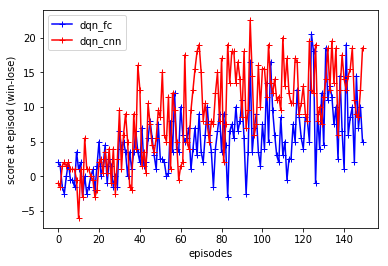

In [18]:
plt.plot(history_scores_dqn_fc,marker="+",color="b",label="dqn_fc")
plt.plot(history_scores_dqn_cnn,marker="+",color="r",label="dqn_cnn")
plt.xlabel("episodes") ; plt.ylabel("score at episod (win-lose)") ; plt.legend()
plt.show()

In [19]:
HTML(display_videos('cnn_train150.mp4')) #last train episode

> The convolutional neural network which led to the best performances is the one above, composed of 2 convolutional layers with 16 small filters of size (3,3), each followed by relu activations, and of 1 final fully connected layer. This convolutional network has 2,692 parameters, against 2,228 for the previous fully connected network, and as we can see on the score evolution curbs, it performs much better than the FCN. I observed however that a larger number of filters or a larger size of filters was detrimental to the scores. In addition, pooling layers particularly decreased performances (probably they compressed too much the information). I again used a learning rate of 0.1, a memory of size 2000, and a batch size of 32 for the training of the CNN, which worked quite well.

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [20]:
agent_dqn_cnn = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_dqn_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_dqn_fc = DQN_FC(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_dqn_fc.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')

for temp in [0.1, 0.3, 0.5]:
    print("TEMPERATURE : ", str(temp))
    env = Environment(grid_size=size, max_time=T,temperature=temp)

    print('Test of the CNN')
    test(agent_dqn_cnn,env,epochs_test,prefix='cnn_test_'+str(temp)+'_')
    print('Test of the FC')
    test(agent_dqn_fc,env,epochs_test,prefix='fc_test_'+str(temp)+'_')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 3, 16)          304       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 16)          2320      
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 2,692
Trainable params: 2,692
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 

Win/lose count 10.0/0. Average score (6.383333333333334)
Final score: 6.383333333333334
TEMPERATURE :  0.5
Test of the CNN
Win/lose count 2.5/1.0. Average score (1.5)
Win/lose count 20.5/1.0. Average score (10.5)
Win/lose count 11.5/0. Average score (10.833333333333334)
Win/lose count 2.5/0. Average score (8.75)
Win/lose count 1.0/0. Average score (7.2)
Win/lose count 24.5/0. Average score (10.083333333333334)
Win/lose count 21.0/0. Average score (11.642857142857142)
Win/lose count 36.0/0. Average score (14.6875)
Win/lose count 22.5/0. Average score (15.555555555555555)
Win/lose count 6.0/0. Average score (14.6)
Win/lose count 3.5/0. Average score (13.590909090909092)
Win/lose count 26.5/0. Average score (14.666666666666666)
Win/lose count 15.0/0. Average score (14.692307692307692)
Win/lose count 24.0/0. Average score (15.357142857142858)
Win/lose count 18.5/0. Average score (15.566666666666666)
Win/lose count 12.0/0. Average score (15.34375)
Win/lose count 4.5/0. Average score (14.705

In [57]:
print("Temperature : 0.3. CNN-DQN")
HTML(display_videos('cnn_test_0.3_1.mp4'))

Temperature : 0.3. CNN-DQN


In [59]:
print("Temperature : 0.1. CNN-DQN")
HTML(display_videos('cnn_test_0.1_1.mp4'))

Temperature : 0.1. CNN-DQN


In [54]:
print("Temperature : 0.5. CNN-DQN")
HTML(display_videos('cnn_test_0.5_2.mp4'))

Temperature : 0.5. CNN-DQN


> The two networks I compared are the two presented above which led the best performances for each type :  the FCN with two hidden layers with 32 and 16 neurons (followed by relu), and the CNN with 2 convolutional layers (16 small filters of size (3,3) each followed by relu) and a final dense layer. I used the samed learning rate of 0.1, the same size of memory of (2000), and the same size of batch (32) for the training of the two networks.

> What's make the comparison particularly interesting is that the two networks architectures, the FCN and the CNN, share the same order of number of parameters (2,692 for the CNN against 2,228 for the FCN)

> Below is a summary of the test performances (average over 30 trajectories) obtained for various test temperatures, after training the agent (150 trajectories) with constant $\epsilon$=0.1 in an environment with temperature 0.3 (the temperature parameter corresponds to the probability that each cell contains a cheese, and to the probability that each cell which does not contain a cheese contains a poison).


| Test temperature | 0.1  | 0.3 | 0.5 |
|------|------|------|------|
|  FCN-DQN - Test Score | 1.7 | 6.4 | 7.7 | 
|  CNN-DQN - Test Score | 3.0 | 8.2 | 13.8 | 

> The higher the test tempertaure, the more the CNN-DQN agent outperforms the FCN-DQN one. These experiments tend to show that the convolutional architecture is more appropriate for the task.

> However, we observe the issue that, throughout the training and at test time, even the CNN-DQN agent has explored only one part of the map.  We can see this behaviour of "limited exploration" notably when the rat does not see any positive reward around him (which happens a lot when the temperature is low), or sees only negative rewards around him (which happens with higher temperatures) : in such cases, the rat often transits from a state to another to go back to the original one several consecutive times. Indeed, it may not anticipate that there are cheese at larger horizons, or that eating a poison is necessary to eat many cheese in the future. That's why we will try to favor exploration, with the decreasing $\epsilon$-greedy policy, and with the array storing the already visited cells by the rat.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.

In [42]:
def train_explore(agent,env, epoch, decay_epsilon = 0.1, prefix=''):
    #epoch : number of training epochs
    
    history_losses = []
    history_scores = []    
    
    score = 0
    
    for e in range(epoch):
            
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        loss = 0

        win = 0
        lose = 0
        
        t = 0

        while not game_over:
            
            # The agent performs an action
            action = agent.act(state, train = True)

            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action, train = True)
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)
            
            t+=1
            
        loss /= t
            
        history_losses.append(loss)
        
        ############
        #Update epsilon
        agent.set_epsilon(agent.epsilon*(1-decay_epsilon))
        ############

        # Save as a mp4
        if (e+1) % 50 == 0:
            env.draw(prefix+str(e+1))

        # Update stats
        score_episode = win-lose
        score += score_episode
        history_scores.append(score_episode)
        
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, score_episode))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
                
class EnvironmentExploring(Environment):
    
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        
        super(EnvironmentExploring, self).__init__(grid_size=grid_size, max_time=max_time, temperature=temperature)

        #third information layer (has the cell been visited by the past ?)
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
    
    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1 

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x -1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x +1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        reward = self.board[self.x, self.y]
        
        if train: #reshaping the reward if the cell was already visited
            reward -= self.malus_position[self.x, self.y]
            
        #the cell has just been visited
        self.malus_position[self.x, self.y] = 0.1
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
                
        #we have one more layer caracterizing a state now
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        
        #state visible for the rat
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]
        
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1 
        
        #third information layer (has the cell been visited by the past ?)
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
        
        self.board[self.x,self.y] = 0
        self.board[self.position < 0] = 0
        
        self.t = 0
        
        #the initial state is visited
        self.malus_position[self.x, self.y] = 0.1
        
        #we have one more layer caracterizing a state now
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [43]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=temperature)

agent_dqn_cnn_explore = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.95, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent_dqn_cnn_explore, env, epochs_train, decay_epsilon = 0.05, prefix='cnn_train_explore')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 3, 3, 16)          448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 1, 16)          2320      
_________________________________________________________________
flatten_10 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
Total params: 2,836
Trainable params: 2,836
Non-trainable params: 0
_________________________________________________________________
Epoch 000/150 | Loss 0.0222 | Win/lose count 11.5/21.90000000000005 (-10.400000000000048)
Epoch 001/150 | Loss 0.0165 | Win/lose count 9.5/27.40000000000011 (-17.90000000000011)
Epoch 002/150 | Loss 0.0160 | Win/lose count 15.0/22.400000000000023 (-7.4000000000000234)
Epo

Epoch 083/150 | Loss 0.0153 | Win/lose count 21.5/9.599999999999982 (11.900000000000018)
Epoch 084/150 | Loss 0.0153 | Win/lose count 25.0/8.299999999999986 (16.700000000000014)
Epoch 085/150 | Loss 0.0156 | Win/lose count 19.5/11.799999999999978 (7.700000000000022)
Epoch 086/150 | Loss 0.0151 | Win/lose count 22.5/13.299999999999976 (9.200000000000024)
Epoch 087/150 | Loss 0.0154 | Win/lose count 22.0/13.099999999999971 (8.900000000000029)
Epoch 088/150 | Loss 0.0150 | Win/lose count 23.5/11.099999999999977 (12.400000000000023)
Epoch 089/150 | Loss 0.0153 | Win/lose count 24.0/16.599999999999984 (7.400000000000016)
Epoch 090/150 | Loss 0.0153 | Win/lose count 24.0/13.79999999999997 (10.20000000000003)
Epoch 091/150 | Loss 0.0156 | Win/lose count 26.5/11.799999999999976 (14.700000000000024)
Epoch 092/150 | Loss 0.0155 | Win/lose count 23.0/12.99999999999997 (10.00000000000003)
Epoch 093/150 | Loss 0.0153 | Win/lose count 23.0/12.999999999999977 (10.000000000000023)
Epoch 094/150 | Loss

In [44]:
HTML(display_videos('cnn_train_explore150.mp4'))

In [45]:
# Comparison

agent_dqn_cnn_explore = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.9, memory_size=2000, batch_size = 32,n_state=3)
agent_dqn_cnn_explore.load(name_weights='cnn_train_exploremodel.h5',name_model='cnn_train_exploremodel.json')

for temp in [0.1, 0.3, 0.5]:
    print("TEMPERATURE : ", str(temp))
    env = EnvironmentExploring(grid_size=size, max_time=T,temperature=temp)

    print('Test of the CNN-DQN with exploration encouragement')
    test(agent_dqn_cnn_explore,env,epochs_test,prefix='cnn_test_explore_'+str(temp)+'_')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 3, 3, 16)          448       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 16)          2320      
_________________________________________________________________
flatten_11 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 68        
Total params: 2,836
Trainable params: 2,836
Non-trainable params: 0
_________________________________________________________________
TEMPERATURE :  0.1
Test of the CNN-DQN with exploration encouragement
Win/lose count 7.0/0. Average score (7.0)
Win/lose count 8.5/0. Average score (7.75)
Win/lose count 6.0/0. Average score (7.166666666666667)
Win/lose count 8.5/0. Average score (7.5)
Win/lose count 5.5/

In [46]:
# Evaluation
print("Temperature : 0.1. CNN-DQN with encouraged exploration.")
HTML(display_videos('cnn_test_explore_0.1_1.mp4'))

Temperature : 0.1. CNN-DQN with encouraged exploration.


In [60]:
print("Temperature : 0.3. CNN-DQN with encouraged exploration.")
HTML(display_videos('cnn_test_explore_0.3_2.mp4'))

Temperature : 0.3. CNN-DQN with encouraged exploration.


In [61]:
print("Temperature : 0.5. CNN-DQN with encouraged exploration.")
HTML(display_videos('cnn_test_explore_0.5_2.mp4'))

Temperature : 0.5. CNN-DQN with encouraged exploration.



> 1) Therefore, I trained for this experiment the DQN rat with the same CNN network architecture, except that its input is now of shape (5,5,3), the third "layer" (called "malus_position" in the code) informing the cat whether or not each cell he sees has been visited by the past (0.1 if visited, 0 otherwise). Thus, the new CNN network had slightly more parameters than the previous one (2,836 against 2,692). 

> 2) Secondly, the reward was reshaped at train time, as it was diminished by a 0.1 malus if the state had already been visited by the past (this can be seen as an exploration bonus).

> 3) Finally, the new trained rat played according to an $\epsilon$-greedy policy, with $\epsilon$-decreasing from 0.95 initially and by a factor 0.05 at each training epoch (for instance $\epsilon$ worths $0.95^{20} = 0.36$ at the end of the 20-th iteration, 0.07 at the end of the 50-th and 0.006 at the end of the 100-th one). Such a decreasing strategy led to much better outcomes than a linearly decreasing $\epsilon$.

>In the table below, I report the performances of the new trained CNN-DQN agent at test time under various temperatures, and compare these to the CNN-DQN rat trained without the "third" layer information, without the reshaped reward, and playing throughout the entire training according to a 0.1-greedy policy.

> | Test temperature | 0.1  | 0.3 | 0.5 |
|------|------|------|------|
|  CNN-DQN classic - Test Score | 3.0 | 8.2 | 13.8 | 
|  CNN-DQN with the three exploration tricks - Test Score | 7.37 | 19.1 | 29.6 |  

> Therefore, we clearly see, both through the average test scores and the sampled test trajectories, the advantage of using these three tricks favoring exploration (notably when rewards are delayed, ie. when several moves of the rat are needed to reach a positive reward).

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

In [49]:
class Mimicker():
    
    def __init__(self, n_state=2, n_action=4):
        
        # number of action
        self.n_action = n_action
        
        # number of state
        self.n_state = n_state
        
        # CNN model to predict the action taken by the expert agent (up,down,left,right) 
        # in a given state
                
        model = Sequential()
    
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(5,5,self.n_state,)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.n_action,activation='softmax'))

        model.summary()
        
        opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
        self.model = model
    
    def act(self,state,train=True):
        return np.argmax(self.model.predict(state[None,:,:,:]).flatten()) #action with highest probability
        
    def learn(self,demonstrations,epochs=100,batch_size=16,prefix='', viz=True):
        
        #demonstrations = trajectories of the expert agent (visited pairs (state,action))
        
        nb_samples = len(demonstrations)
        states = np.zeros((nb_samples,5,5,self.n_state))
        actions = np.zeros((nb_samples,self.n_action))
        for (idx,(state, action)) in enumerate(demonstrations):
            states[idx] = state 
            actions[idx] = to_categorical(action,self.n_action)
                                
        early_stopping_monitor = EarlyStopping(patience = 5)
        
        history = self.model.fit(states,actions,
                                 batch_size=batch_size,epochs=epochs,
                                 validation_split = 0.2,callbacks=[early_stopping_monitor],
                                 verbose=1)
        
        if viz:
            plt.plot(history.history['loss'],marker="+",color="b",label="train")
            plt.plot(history.history['val_loss'],marker="+",color="r",label="valid")
            plt.xlabel("epochs") ; plt.ylabel("loss") ; plt.legend()
            plt.show()

        self.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        
        opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  
        
        self.model = model

In [50]:
#collecting trajectories of the expert CNN-DQN agent

nb_demonstrations = 100
env = EnvironmentExploring(grid_size=size, max_time=T,temperature=temperature)
demonstrations = test(agent_dqn_cnn_explore,env,nb_demonstrations,prefix='cnn_test_explore', return_trajectories=True)

Win/lose count 19.5/2.0. Average score (17.5)
Win/lose count 25.0/2.0. Average score (20.25)
Win/lose count 18.0/4.0. Average score (18.166666666666668)
Win/lose count 28.5/0. Average score (20.75)
Win/lose count 23.0/3.0. Average score (20.6)
Win/lose count 23.0/3.0. Average score (20.5)
Win/lose count 24.0/5.0. Average score (20.285714285714285)
Win/lose count 21.0/3.0. Average score (20.0)
Win/lose count 19.0/0. Average score (19.88888888888889)
Win/lose count 26.5/4.0. Average score (20.15)
Win/lose count 19.0/1.0. Average score (19.954545454545453)
Win/lose count 29.0/3.0. Average score (20.458333333333332)
Win/lose count 14.0/0. Average score (19.96153846153846)
Win/lose count 21.0/2.0. Average score (19.892857142857142)
Win/lose count 26.0/4.0. Average score (20.033333333333335)
Win/lose count 24.0/3.0. Average score (20.09375)
Win/lose count 22.0/3.0. Average score (20.029411764705884)
Win/lose count 16.5/2.0. Average score (19.72222222222222)
Win/lose count 26.0/2.0. Average s

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 3, 3, 16)          448       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 16)          2320      
_________________________________________________________________
flatten_12 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 68        
Total params: 2,836
Trainable params: 2,836
Non-trainable params: 0
_________________________________________________________________
Train on 16080 samples, validate on 4020 samples
Epoch 1/100
16080/16080 [==============================] - 2s 155us/step - loss: 0.8896 - acc: 0.6139 - val_loss: 0.6878 - val_acc: 0.7226
Epoch 2/100
16080/16080 [==============================] - 2s 131us/step - loss: 0.5

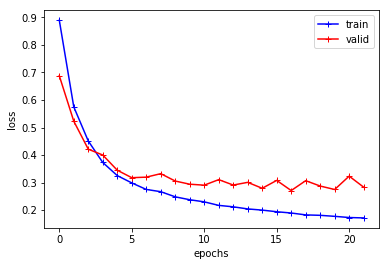

In [51]:
#training the CNN Mimicker Agent with the pair (states,actions) of the CNN-DQN agent trajectories

agent_mimicker = Mimicker(n_state=3, n_action=4)
agent_mimicker.learn(demonstrations,epochs=100,batch_size=32,prefix='mimicker_train', viz=True)

In [52]:
# Evaluation

test(agent_mimicker,env,epochs_test,prefix='mimicker_test')
HTML(display_videos('mimicker_test1.mp4'))

Win/lose count 21.5/1.0. Average score (20.5)
Win/lose count 24.0/2.0. Average score (21.25)
Win/lose count 23.5/2.0. Average score (21.333333333333332)
Win/lose count 16.0/2.0. Average score (19.5)
Win/lose count 24.0/3.0. Average score (19.8)
Win/lose count 7.0/0. Average score (17.666666666666668)
Win/lose count 24.5/3.0. Average score (18.214285714285715)
Win/lose count 24.5/3.0. Average score (18.625)
Win/lose count 16.0/6.0. Average score (17.666666666666668)
Win/lose count 27.0/1.0. Average score (18.5)
Win/lose count 16.5/0. Average score (18.318181818181817)
Win/lose count 13.0/1.0. Average score (17.791666666666668)
Win/lose count 9.5/1.0. Average score (17.076923076923077)
Win/lose count 27.5/2.0. Average score (17.678571428571427)
Win/lose count 20.5/4.0. Average score (17.6)
Win/lose count 21.0/3.0. Average score (17.625)
Win/lose count 22.5/6.0. Average score (17.558823529411764)
Win/lose count 28.0/3.0. Average score (17.97222222222222)
Win/lose count 25.5/6.0. Average s

In [53]:
# Comparison performances

for temp in [0.1,0.3,0.5]:
    print("TEMPERATURE : ", str(temp))
    env = EnvironmentExploring(grid_size=size, max_time=T,temperature=temp)
    
    print('Test of the Mimicker Agent')
    test(agent_mimicker,env,epochs_test)

TEMPERATURE :  0.1
Test of the Mimicker Agent
Win/lose count 7.5/0. Average score (7.5)
Win/lose count 9.0/1.0. Average score (7.75)
Win/lose count 6.0/0. Average score (7.166666666666667)
Win/lose count 14.5/1.0. Average score (8.75)
Win/lose count 7.5/1.0. Average score (8.3)
Win/lose count 6.0/0. Average score (7.916666666666667)
Win/lose count 10.5/0. Average score (8.285714285714286)
Win/lose count 8.0/0. Average score (8.25)
Win/lose count 10.5/0. Average score (8.5)
Win/lose count 8.5/2.0. Average score (8.3)
Win/lose count 8.5/1.0. Average score (8.227272727272727)
Win/lose count 13.0/1.0. Average score (8.541666666666666)
Win/lose count 7.0/0. Average score (8.423076923076923)
Win/lose count 8.0/0. Average score (8.392857142857142)
Win/lose count 7.0/1.0. Average score (8.233333333333333)
Win/lose count 4.0/2.0. Average score (7.84375)
Win/lose count 5.0/0. Average score (7.676470588235294)
Win/lose count 7.0/0. Average score (7.638888888888889)
Win/lose count 5.5/0. Average s

> In order to train an agent just by showing him trajectories of an expert agent, I first collected 100 test trajectories of horizon T=200 performed by the CNN-DQN agent trained with exploration tricks. Then I trained the "Mimicker" Agent, which is not more than a CNN which aims at predicting which action was taken by the expert CNN-DQN (values from 0 to 3) in each state (array of size (5,5,3)). I again used for the CNN architecture 2 convolutional layers (16 small filters of size (3,3) each followed by relu) and a final dense layer, and I used the categorical cross-entropy loss, adequate for this classification task.

>In the table below, I report the performances at test time, under various temperatures, of the Mimicker Agent, against those of the expert DQN Agent he learnt from.

> | Test temperature | 0.1  | 0.3 | 0.5 |
|------|------|------|------|
|  Expert : CNN-DQN with the three exploration tricks - Test Score | 7.37 | 19.1 | 29.6 |  
|  Mimicker of the expert - Test Score | 7.7 | 18.8 | 28.8 | 

> The Mimicker agent reaches performances which are very close to the ones of the expert which showed him its trajectories. This demonstrates the effectiveness of this supervised approach to problems traditionnally tackled by the reinforcement learning formalization (learn by trial and error), assumed that we can collect demonstrations from expert agents.